## Description

In this notebook, I compare the accuracy of 4 approaches: either peak-based or regression-based and either K-means or spatialDGMM.  

## Data & module imports

In [1]:
%matplotlib notebook

In [2]:
import imageio
import numpy as np
import numpy.random as rd 
from masserstein import Spectrum, estimate_proportions
from matplotlib import cm
from matplotlib import pyplot as plt
from pyimzml.ImzMLWriter import ImzMLWriter
from pyimzml.ImzMLParser import ImzMLParser
from copy import deepcopy
from scipy.stats import nbinom, pearsonr
from sklearn.cluster import KMeans

Loading background image:

In [13]:
mask = imageio.imread('SimulationMask.png')
mask.shape

(40, 40, 4)

In [4]:
region1 = mask[:,:,1] == 128
region2 = mask[:,:,1] == 46
region3 = mask[:,:,1] == 130
region4 = mask[:,:,1] == 53

Names of lipids:

In [5]:
lipid_names = ['PC(38:1)', 'PA(44:0)', 'PC(38:0)']

Regions of monoisotopic peaks to integrate to get peak areas:

In [6]:
integration_regions = [
    (854.4, 854.8),
    (855.4, 855.8),
    (856.4, 856.8)
]

Regions enriched in lipids:

In [21]:
enrichment_mask = np.zeros(mask.shape[:2] + (len(lipid_names),), dtype='bool')
enrichment_mask[...,0] = region1 + region3
enrichment_mask[...,1] = region2 + region4
enrichment_mask[...,2] = region3 + region4

Loading profile image:

In [7]:
MSI_profile = ImzMLParser('lipid_MSI_profile_mode.imzML')

/home/ciach/Py3Env/lib/python3.8/site-packages/pyimzml/ontology/ontology.py:86: UserWarning: Accession IMS:1000491 found with incorrect name "line scan left right". Updating name to "linescan left right".
  warn(


Calculating monoisotopic peak signals:

In [8]:
monoisotopic_peak_areas = np.zeros(mask.shape[:-1] + (3,))
for idx, (xcoord,ycoord,zcoord) in enumerate(MSI_profile.coordinates):
    mz, intsy = MSI_profile.getspectrum(idx)
    mz, intsy = np.array(mz), np.array(intsy)
    for region_id, region in enumerate(integration_regions):
        to_take = (mz >= region[0])*(mz <= region[1])
        area = np.trapz(intsy[to_take], mz[to_take])
        monoisotopic_peak_areas[ycoord, xcoord, region_id] = area

Loading deconvolution results:

In [9]:
deconvolution_image = np.zeros(mask.shape[:-1] + (3,))
with open('lipid_regression_results.tsv') as h:
    next(h)
    for l in h:
        l = l.strip().split('\t')
        x, y = map(int, l[:2])
        deconvolution_image[y, x, ...] = list(map(float, l[2:]))

Loading Dan's clustering results:

In [26]:
peak_kmeans_segments = np.zeros(mask.shape[:-1] + (3,))
with open('km_simulation.csv') as h:
    next(h) # skip the header
    for l in h:
        l = l.split(',')[1:]
        l = list(map(int, l))
        peak_kmeans_segments[l[1],l[0],...] = l[2:]
peak_kmeans_segments -= 1  # to get a binary classification

In [27]:
peak_sdgmm_segments = np.zeros(mask.shape[:-1] + (3,))
with open('sdgmm_simulation.csv') as h:
    next(h) # skip the header
    for l in h:
        l = l.split(',')[1:]
        l = list(map(int, l))
        peak_sdgmm_segments[l[1],l[0],...] = l[2:]
peak_sdgmm_segments -= 1   # to get a binary classification

Do a k-means clustering of peaks for data validation:

In [28]:
nclust = 2
peak_kmeans_segments_replicated = np.zeros(mask.shape[:-1] + (3,))
for lipid_id, lipid_name in enumerate(lipid_names):
    peak_intensities = monoisotopic_peak_areas[...,lipid_id]
    peak_intensities = peak_intensities.reshape((-1,1))
    peak_kmeans = KMeans(n_clusters=nclust)
    region_classification = peak_kmeans.fit_predict(peak_intensities)
    region_classification = region_classification.reshape(40, 40)
    peak_intensities = peak_intensities.reshape((40, 40))
    region_classification = np.argsort(np.argsort(peak_kmeans.cluster_centers_.reshape((-1,))))[region_classification]
    peak_kmeans_segments_replicated[..., lipid_id] = region_classification 

## Data visualization

<IPython.core.display.Javascript object>


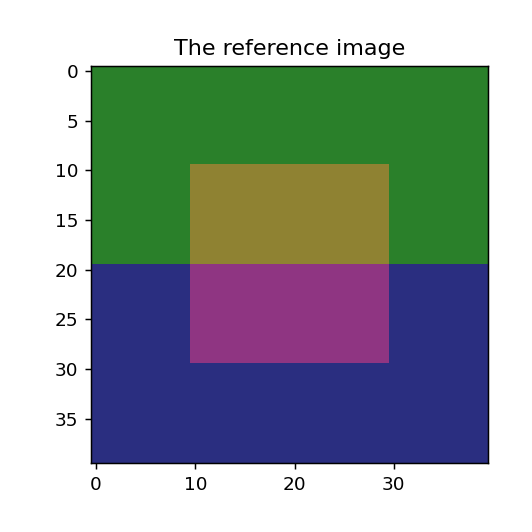

In [4]:
plt.figure(figsize=(3,3))
plt.title('The reference image')
plt.imshow(mask)
plt.tight_layout()
plt.show()

Ion images, monoisotopic peak

<IPython.core.display.Javascript object>


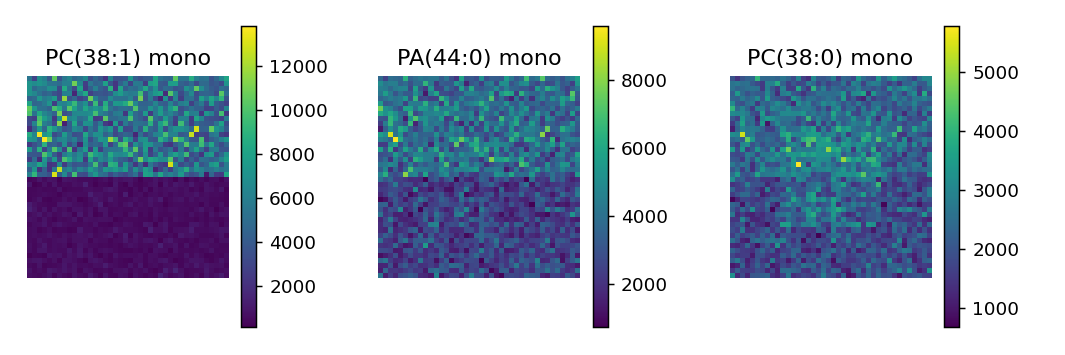

In [31]:
plt.subplots(1, 3, figsize=(6,2))
for lipid_id, lipid_name in enumerate(lipid_names):
    plt.subplot(1, 3, 1 + lipid_id)
    plt.title(lipid_name + ' mono')
    plt.imshow(monoisotopic_peak_areas[:,:,lipid_id])
    plt.axis('off')
    plt.colorbar()
plt.tight_layout()
plt.show()

Ion images, deconvoluted

<IPython.core.display.Javascript object>


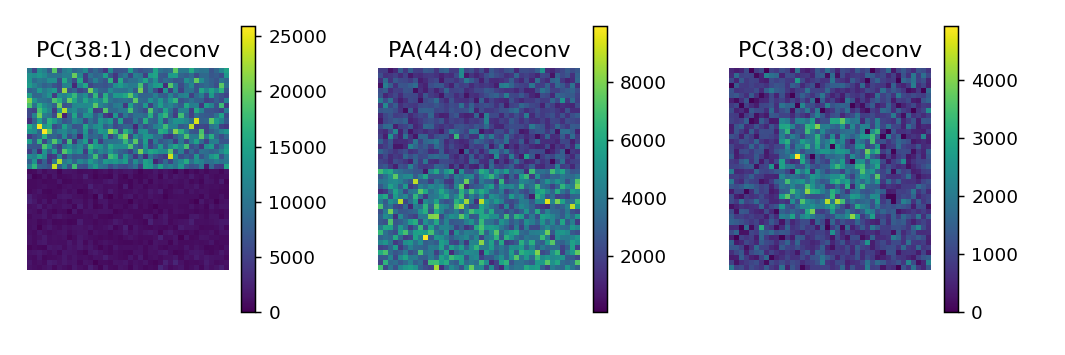

In [26]:
plt.subplots(1, 3, figsize=(6,2))
for lipid_id, lipid_name in enumerate(lipid_names):
    plt.subplot(1, 3, 1 + lipid_id)
    plt.title(lipid_name + ' deconv')
    plt.imshow(deconvolution_image[:,:,lipid_id])
    plt.axis('off')
    plt.colorbar()
plt.tight_layout()
plt.show()

K-means clustering (Dan), monoisotopic peak

<IPython.core.display.Javascript object>


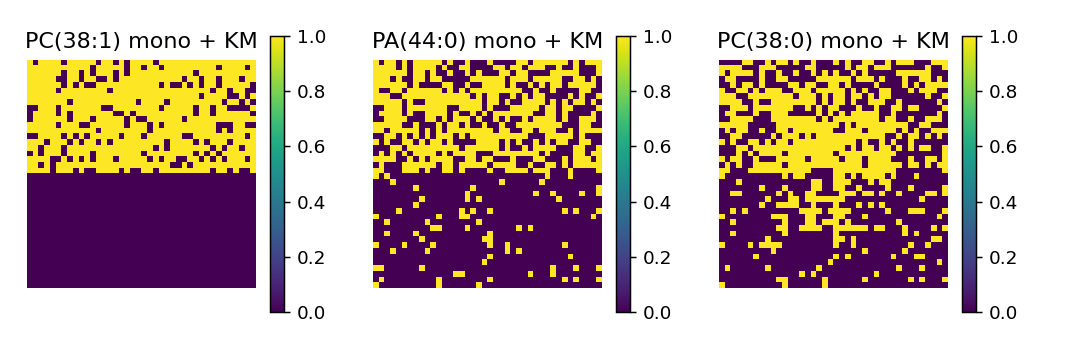

In [33]:
plt.subplots(1, 3, figsize=(6,2))
for lipid_id, lipid_name in enumerate(lipid_names):
    plt.subplot(1, 3, 1 + lipid_id)
    plt.title(lipid_name + ' mono + KM')
    plt.imshow(peak_kmeans_segments[:,:,lipid_id])
    plt.axis('off')
    plt.colorbar()
plt.tight_layout()
plt.show()

Local K-means to check data consistency:

<IPython.core.display.Javascript object>


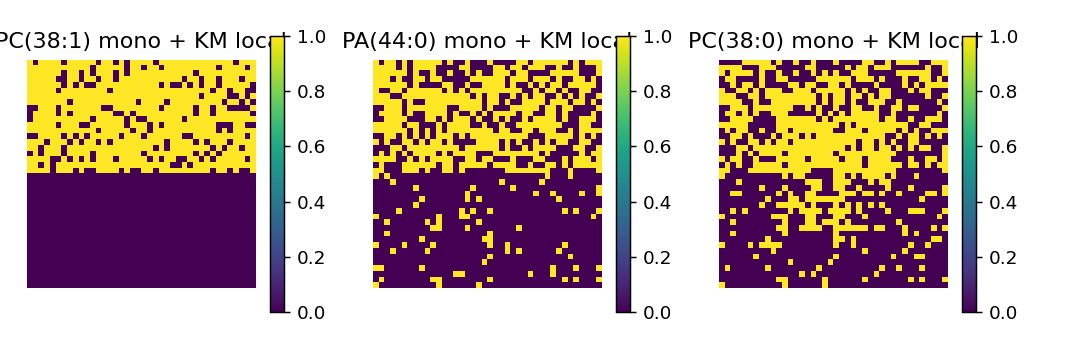

In [32]:
plt.subplots(1, 3, figsize=(6,2))
for lipid_id, lipid_name in enumerate(lipid_names):
    plt.subplot(1, 3, 1 + lipid_id)
    plt.title(lipid_name + ' mono + KM local')
    plt.imshow(peak_kmeans_segments_replicated[:,:,lipid_id])
    plt.axis('off')
    plt.colorbar()
plt.tight_layout()
plt.show()

Small differences as expected (probably local minimum), overall good consistency

spatialDGMM clustering (Dan), mono

<IPython.core.display.Javascript object>


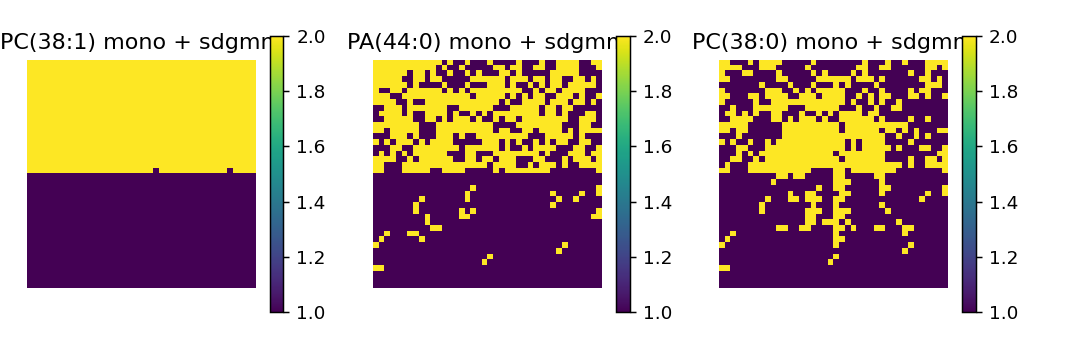

In [44]:
plt.subplots(1, 3, figsize=(6,2))
for lipid_id, lipid_name in enumerate(lipid_names):
    plt.subplot(1, 3, 1 + lipid_id)
    plt.title(lipid_name + ' mono + sdgmm')
    plt.imshow(peak_sdgmm_segments[:,:,lipid_id])
    plt.axis('off')
    plt.colorbar()
plt.tight_layout()
plt.show()

## Accuracy computation

In [29]:
nclust = 2

peak_kmeans_accuracy = [0.]*len(lipid_names)
ws_kmeans_accuracy = [0.]*len(lipid_names)
peak_sdgmm_accuracy = [0.]*len(lipid_names)
ws_sdgmm_accuracy = [0.]*len(lipid_names)

peak_kmeans_correlation = [0.]*len(lipid_names)
ws_kmeans_correlation = [0.]*len(lipid_names)
peak_sdgmm_correlation = [0.]*len(lipid_names)
ws_sdgmm_correlation = [0.]*len(lipid_names)

for lipid_id, lipid_name in enumerate(lipid_names):
    # Peak K-means
    region_classification = kmeans_segments[..., lipid_id]
    peak_kmeans_accuracy[lipid_id] = np.sum(region_classification * enrichment_mask[...,lipid_id])/np.sum(enrichment_mask[...,lipid_id])
    peak_kmeans_correlation[lipid_id] = pearsonr(region_classification.flatten(), enrichment_mask[...,lipid_id].flatten())[0]
    # Peak spatialDGMM
    region_classification = sdgmm_segments[..., lipid_id]
    peak_sdgmm_accuracy[lipid_id] = np.sum(region_classification * enrichment_mask[...,lipid_id])/np.sum(enrichment_mask[...,lipid_id])
    peak_sdgmm_correlation[lipid_id] = pearsonr(region_classification.flatten(), enrichment_mask[...,lipid_id].flatten())[0]
    

In [31]:
print('Accuracy of segmentation:')
print('Lipid\tAlgorithm\tPeak\tWS')
for i, n in enumerate(lipid_names):
    print(n, 'K-means', peak_kmeans_accuracy[i], ws_kmeans_accuracy[i], sep='\t')
for i, n in enumerate(lipid_names):
    print(n, 'sDGMM', peak_sdgmm_accuracy[i], ws_sdgmm_accuracy[i], sep='\t')
print()
print('Correlation of segmentation:')
print('Lipid\tAlgorithm\tPeak\tWS')
for i, n in enumerate(lipid_names):
    print(n, 'K-means', round(peak_kmeans_correlation[i], 2), round(ws_kmeans_correlation[i], 2), sep='\t')
for i, n in enumerate(lipid_names):
    print(n, 'sDGMM', round(peak_sdgmm_correlation[i], 2), round(ws_sdgmm_correlation[i], 2), sep='\t')

Accuracy of segmentation:
Lipid	Algorithm	Peak	WS
PC(38:1)	K-means	0.79625	0.0
PA(44:0)	K-means	0.0975	0.0
PC(38:0)	K-means	0.645	0.0
PC(38:1)	sDGMM	0.9975	0.0
PA(44:0)	sDGMM	0.045	0.0
PC(38:0)	sDGMM	0.5775	0.0

Correlation of segmentation:
Lipid	Algorithm	Peak	WS
PC(38:1)	K-means	0.81	0.0
PA(44:0)	K-means	-0.53	0.0
PC(38:0)	K-means	0.3	0.0
PC(38:1)	sDGMM	1.0	0.0
PA(44:0)	sDGMM	-0.62	0.0
PC(38:0)	sDGMM	0.34	0.0
